# Simple benchmark without Annime

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


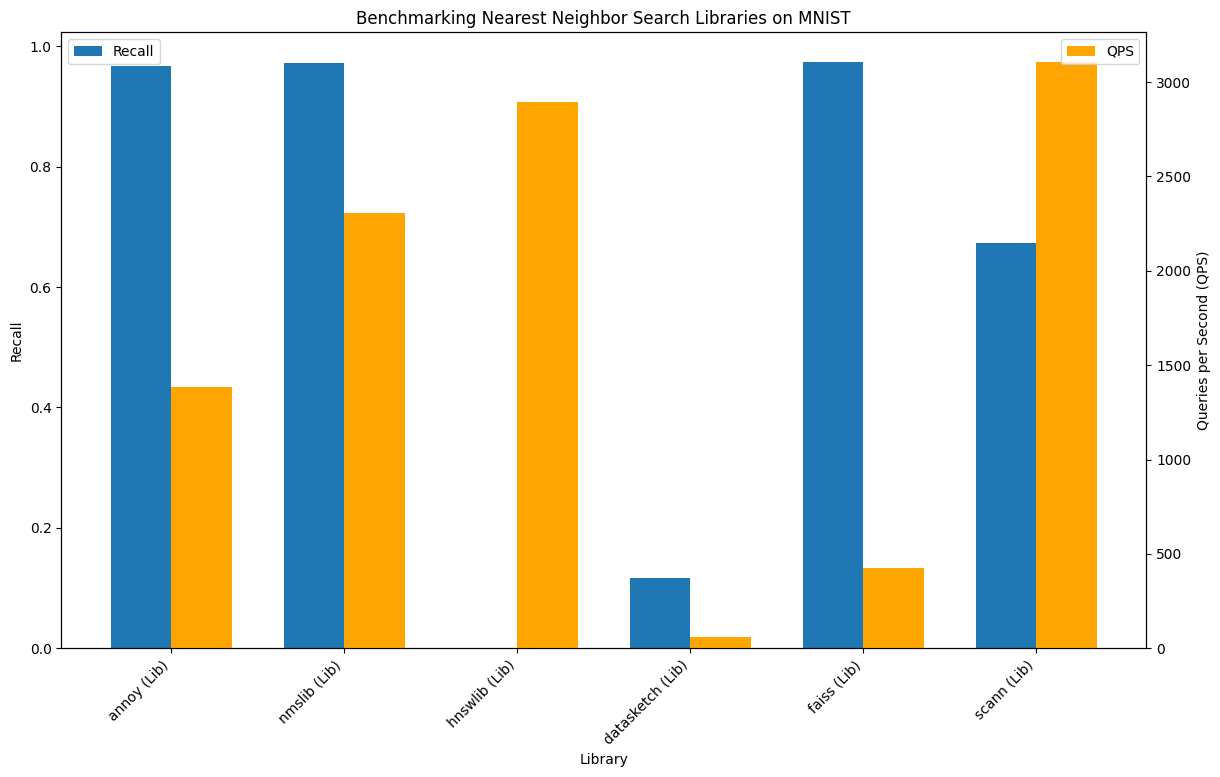

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.datasets import fetch_openml

def load_mnist():
    """
    Load the MNIST dataset and split into train and test sets.

    Returns:
        X_train (np.ndarray): Training data.
        X_test (np.ndarray): Testing data.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
    """
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.to_numpy()
    y = mnist.target.astype(int).to_numpy()

    # Split the dataset into training and testing sets
    num_train = int(0.9 * len(X))
    X_train, X_test = X[:num_train], X[num_train:]
    y_train, y_test = y[:num_train], y[num_train:]

    return X_train, X_test, y_train, y_test

def benchmark_without_class(library, X_train, X_test, y_train, y_test):
    """
    Benchmark using the library directly.

    Args:
        library: The library to benchmark.
        X_train (np.ndarray): Training data.
        X_test (np.ndarray): Testing data.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.

    Returns:
        recall (float): Recall of the nearest neighbor search.
        qps (float): Queries per second.
    """
    if library == 'annoy':
        from annoy import AnnoyIndex
        index = AnnoyIndex(X_train.shape[1], 'euclidean')
        for i in range(X_train.shape[0]):
            index.add_item(i, X_train[i])
        index.build(10)

        start_time = time.time()
        results = []
        for x in X_test:
            query_result = index.get_nns_by_vector(x, 1)
            if query_result:
                results.append(y_train[query_result[0]])
            else:
                results.append(-1)
        qps = len(X_test) / (time.time() - start_time)
        valid_indices = [i for i, res in enumerate(results) if res != -1]
        valid_y_test = y_test[valid_indices]
        valid_results = [results[i] for i in valid_indices]
        recall = recall_score(valid_y_test, valid_results, average='macro')
        return recall, qps

    elif library == 'nmslib':
        import nmslib
        index = nmslib.init(method='hnsw', space='l2')
        index.addDataPointBatch(X_train)
        index.createIndex()

        start_time = time.time()
        results = []
        for x in X_test:
            query_result = index.knnQuery(x, k=1)
            if query_result[0]:
                results.append(y_train[query_result[0][0]])
            else:
                results.append(-1)
        qps = len(X_test) / (time.time() - start_time)
        valid_indices = [i for i, res in enumerate(results) if res != -1]
        valid_y_test = y_test[valid_indices]
        valid_results = [results[i] for i in valid_indices]
        recall = recall_score(valid_y_test, valid_results, average='macro')
        return recall, qps

    elif library == 'hnswlib':
        import hnswlib
        dim = X_train.shape[1]
        num_elements = X_train.shape[0]
        p = hnswlib.Index(space='l2', dim=dim)
        p.init_index(max_elements=num_elements, ef_construction=200, M=16)
        p.add_items(X_train, np.arange(num_elements))
        p.set_ef(50)

        start_time = time.time()
        results = p.knn_query(X_test, k=1)[0].flatten()
        qps = len(X_test) / (time.time() - start_time)
        recall = recall_score(y_test, results, average='macro')
        return recall, qps

    elif library == 'datasketch':
        from datasketch import MinHash, MinHashLSH
        lsh = MinHashLSH(threshold=0.5, num_perm=128)
        id_map = {}
        for i, x in enumerate(X_train):
            minhash = MinHash(num_perm=128)
            for dim in x:
                minhash.update(str(dim).encode('utf8'))
            point_id = f"point_{i}"
            lsh.insert(point_id, minhash)
            id_map[point_id] = i

        start_time = time.time()
        results = []
        for x in X_test:
            minhash = MinHash(num_perm=128)
            for dim in x:
                minhash.update(str(dim).encode('utf8'))
            result = lsh.query(minhash)
            if result:
                results.append(y_train[id_map[result[0]]] if result else -1)
            else:
                results.append(-1)
        qps = len(X_test) / (time.time() - start_time)
        valid_indices = [i for i, res in enumerate(results) if res != -1]
        valid_y_test = y_test[valid_indices]
        valid_results = [results[i] for i in valid_indices]
        recall = recall_score(valid_y_test, valid_results, average='macro')
        return recall, qps

    elif library == 'faiss':
        import faiss
        index = faiss.IndexFlatL2(X_train.shape[1])
        index.add(X_train.astype(np.float32))

        start_time = time.time()
        _, I = index.search(X_test.astype(np.float32), 1)
        qps = len(X_test) / (time.time() - start_time)
        recall = recall_score(y_test, y_train[I.flatten()], average='macro')
        return recall, qps

    elif library == 'scann':
        import scann
        searcher = scann.scann_ops_pybind.builder(X_train, 10, "dot_product").tree(
            num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
            2, anisotropic_quantization_threshold=0.2).reorder(100).build()

        start_time = time.time()
        results, _ = searcher.search_batched(X_test, final_num_neighbors=1)
        qps = len(X_test) / (time.time() - start_time)
        recall = recall_score(y_test, y_train[results.flatten()], average='macro')
        return recall, qps

def run_benchmarks():
    """
    Run all benchmarks and return the results.
    """
    X_train, X_test, y_train, y_test = load_mnist()

    lib_benchmarks = {
        'annoy': 'annoy',
        'nmslib': 'nmslib',
        'hnswlib': 'hnswlib',
        'datasketch': 'datasketch',
        'faiss': 'faiss',
        'scann': 'scann',
    }

    results = {}
    for name, library in lib_benchmarks.items():
        recall, qps = benchmark_without_class(library, X_train, X_test, y_train, y_test)
        results[name + ' (Lib)'] = {'recall': recall, 'qps': qps}

    return results

def plot_results(results):
    """
    Plot the benchmark results.

    Args:
        results (dict): Dictionary containing recall and QPS for each library.
    """
    labels = list(results.keys())
    recall_scores = [results[label]['recall'] for label in labels]
    qps_scores = [results[label]['qps'] for label in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax2 = ax1.twinx()
    ax1.bar(x - width / 2, recall_scores, width, label='Recall')
    ax2.bar(x + width / 2, qps_scores, width, label='QPS', color='orange')

    ax1.set_xlabel('Library')
    ax1.set_ylabel('Recall')
    ax2.set_ylabel('Queries per Second (QPS)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Benchmarking Nearest Neighbor Search Libraries on MNIST')
    plt.show()

# Run benchmarks and plot results
results = run_benchmarks()
plot_results(results)


# Simple benchmark with Annime

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


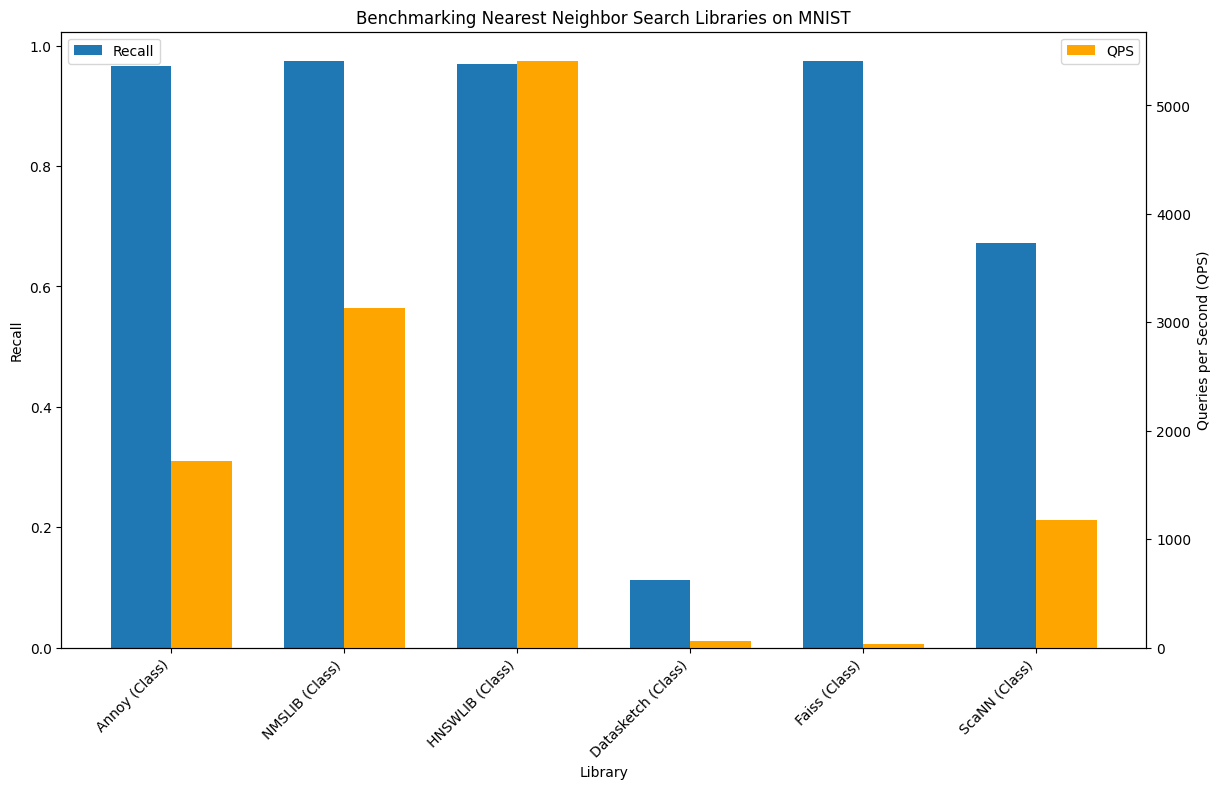

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.datasets import fetch_openml

# Import custom ANN classes
from annime.annoy_int import AnnoyANN
from annime.datasketch_ann import DatasketchANN
from annime.faiss_int import FaissANN
from annime.hnswlib_int import HnswlibANN
from annime.nmslib_int import NmslibANN
from annime.scann_int import ScannANN

def load_mnist():
    """
    Load the MNIST dataset and split into train and test sets.

    Returns:
        X_train (np.ndarray): Training data.
        X_test (np.ndarray): Testing data.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
    """
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.to_numpy()
    y = mnist.target.astype(int).to_numpy()

    # Split the dataset into training and testing sets
    num_train = int(0.9 * len(X))
    X_train, X_test = X[:num_train], X[num_train:]
    y_train, y_test = y[:num_train], y[num_train:]

    return X_train, X_test, y_train, y_test

def benchmark_with_class(ann_class, init_params, X_train, X_test, y_train, y_test):
    """
    Benchmark using a custom ANN class.

    Args:
        ann_class: The ANN class to benchmark.
        init_params (dict): The initialization parameters for the ANN class.
        X_train (np.ndarray): Training data.
        X_test (np.ndarray): Testing data.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.

    Returns:
        recall (float): Recall of the nearest neighbor search.
        qps (float): Queries per second.
    """
    ann_instance = ann_class(**init_params)
    ann_instance.build_index(X_train)

    start_time = time.time()
    results = []
    for x in X_test:
        query_result = ann_instance.query(x, k=1)
        if query_result and query_result[0] != -1:
            if isinstance(query_result[0], list):
                results.append(y_train[query_result[0][0]])
            else:
                results.append(y_train[query_result[0]])
        else:
            results.append(-1)
    qps = len(X_test) / (time.time() - start_time)
    valid_indices = [i for i, res in enumerate(results) if res != -1]
    valid_y_test = y_test[valid_indices]
    valid_results = [results[i] for i in valid_indices]
    recall = recall_score(valid_y_test, valid_results, average='macro')
    return recall, qps

def run_benchmarks():
    """
    Run all benchmarks and return the results.
    """
    X_train, X_test, y_train, y_test = load_mnist()

    class_benchmarks = {
        'Annoy (Class)': (AnnoyANN, {'dim': X_train.shape[1], 'metric': 'euclidean'}),
        'NMSLIB (Class)': (NmslibANN, {}),
        'HNSWLIB (Class)': (HnswlibANN, {'dim': X_train.shape[1]}),
        'Datasketch (Class)': (DatasketchANN, {}),
        'Faiss (Class)': (FaissANN, {'dim': X_train.shape[1]}),
        'ScaNN (Class)': (ScannANN, {'num_neighbors': 10, 'distance_measure': 'dot_product'})
    }

    results = {}
    for name, (ann_class, init_params) in class_benchmarks.items():
        recall, qps = benchmark_with_class(ann_class, init_params, X_train, X_test, y_train, y_test)
        results[name] = {'recall': recall, 'qps': qps}

    return results

def plot_results(results):
    """
    Plot the benchmark results.

    Args:
        results (dict): Dictionary containing recall and QPS for each library.
    """
    labels = list(results.keys())
    recall_scores = [results[label]['recall'] for label in labels]
    qps_scores = [results[label]['qps'] for label in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax2 = ax1.twinx()
    ax1.bar(x - width / 2, recall_scores, width, label='Recall')
    ax2.bar(x + width / 2, qps_scores, width, label='QPS', color='orange')

    ax1.set_xlabel('Library')
    ax1.set_ylabel('Recall')
    ax2.set_ylabel('Queries per Second (QPS)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Benchmarking Nearest Neighbor Search Libraries on MNIST')
    plt.show()

# Run benchmarks and plot results
results = run_benchmarks()
plot_results(results)


# Sklearn pipeline example

In [ ]:
# Example for AnnoyANN
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import recall_score
import time

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.to_numpy()
y = mnist.target.astype(int).to_numpy()

# Split the data
num_train = int(0.9 * len(X))
X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

# Create and fit AnnoyANN
annoy_ann = AnnoyANN(dim=X_train.shape[1], metric='euclidean')
annoy_ann.fit(X_train)

# Transform the data
start_time = time.time()
y_pred_indices = annoy_ann.transform(X_test)
end_time = time.time()

# Calculate recall
y_pred = [y_train[idx] for idx in y_pred_indices.flatten()]
recall = recall_score(y_test, y_pred, average='macro')
print(f"AnnoyANN Recall: {recall}")

# Calculate QPS
qps = len(X_test) / (end_time - start_time)
print(f"AnnoyANN QPS: {qps}")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


AnnoyANN Recall: 0.9665566822096825
AnnoyANN QPS: 2365.1576419835565
